In [1]:
# Standard library imports
import os
import random

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.spatial.distance import cosine
from scipy.cluster.vq import kmeans, vq
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, silhouette_score, silhouette_samples, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Input, LSTM, BatchNormalization, Dropout, Lambda, Multiply, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Create relative path method to access all the files in data/raw/train folder
def relative_path(path):
    return os.path.join(os.getcwd(), path)

In [3]:
def evaluate(final_df, stream,final_predictions):
    # Calculate F1 Score
    f1 = f1_score(final_df['actual_anomaly'], final_df['predicted_labels'])
    print(f"F1 Score: {f1}")
    # True Positives
    tp_filter = (final_df['actual_anomaly'] == 1) & (final_df['predicted_labels'] == 1)
    # True Negatives
    tn_filter = (final_df['actual_anomaly'] == 0) & (final_df['predicted_labels'] == 0)
    # False Positives
    fp_filter = (final_df['actual_anomaly'] == 0) & (final_df['predicted_labels'] == 1)
    # False Negatives
    fn_filter = (final_df['actual_anomaly'] == 1) & (final_df['predicted_labels'] == 0)
    # Precision
    precision = len(final_df[tp_filter]) / (len(final_df[tp_filter]) + len(final_df[fp_filter]))
    # Recall
    recall = len(final_df[tp_filter]) / (len(final_df[tp_filter]) + len(final_df[fn_filter]))
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f'False Negatives: {len(final_df[fn_filter])}')
    print(f'False Positives: {len(final_df[fp_filter])}')
    print(f'True Negatives: {len(final_df[tn_filter])}')
    print(f'True Positives: {len(final_df[tp_filter])}')
    
    # Add evaluation Metrics to .csv file for on sample where chan_id == stream
    final_predictions.loc[final_predictions['chan_id'] == stream, 'f1'] = f1
    final_predictions.loc[final_predictions['chan_id'] == stream, 'precision'] = precision
    final_predictions.loc[final_predictions['chan_id'] == stream, 'recall'] = recall
    final_predictions.loc[final_predictions['chan_id'] == stream, 'tp'] = len(final_df[tp_filter])
    final_predictions.loc[final_predictions['chan_id'] == stream, 'tn'] = len(final_df[tn_filter])
    final_predictions.loc[final_predictions['chan_id'] == stream, 'fp'] = len(final_df[fp_filter])
    final_predictions.loc[final_predictions['chan_id'] == stream, 'fn'] = len(final_df[fn_filter])
    
    # calculate range or sequence of anomalies predicted
    predicted_anomalies = []
    start = 0
    end = 0
    while end < len(final_df):
        slice = final_df.iloc[start:end+1]
        if not slice.empty:
            if slice['predicted_labels'].iloc[0] == 1:
                if start == 0:
                    start = end
            else:
                if start != 0:
                    end = end - 1
                    predicted_anomalies.append([start,end])
                    start = 0
        if end < len(final_df):
            end += 1
    final_predictions.loc[final_predictions['chan_id'] == stream, 'predicted_anomalies'] = str(predicted_anomalies)
    return final_predictions

In [4]:
def distances_recon_concat_ground_truth(final_df, labeled_anomalies, stream):
    # Extract the anomaly sequences for the given stream
    anomaly_sequences = labeled_anomalies[labeled_anomalies['chan_id'] == stream]['anomaly_sequences'].tolist()

    # Convert the string representation of list to actual list
    actual_anomalies = [eval(seq) for seq in anomaly_sequences]
    
    # Get the number of values for the given stream
    num_values = labeled_anomalies.loc[labeled_anomalies['chan_id'] == stream, 'num_values'].values[0]

    # Initialize a binary array with zeros of length num_values
    binary_labels = np.zeros(num_values)

    # Iterate through all sequences and mark the anomalies
    for anomaly in actual_anomalies:
        for start, end in anomaly:  # Assuming anomaly is a list of [start, end] lists
            binary_labels[start:end + 1] = 1

    # Create a DataFrame from the binary_labels array
    binary_frame = pd.DataFrame(binary_labels, columns=['actual_anomaly'])

    # Concatenate the new binary_frame with the final_df
    final_df = pd.concat([final_df.reset_index(drop=True), binary_frame.reset_index(drop=True)], axis=1)

    return final_df

In [5]:
def train_autoencoder(train_df, test_df,activation_function):
    # Split the data into train and test sets
    # X_train, X_test = train_test_split(train_df.values, test_size=0.2, random_state=42)
    
    # Define the dimensions of the latent space
    latent_dim = 8
    input_dim = train_df.shape[1]
    # Create an autoencoder model with dropout layers
    # activity_regularizer=regularizers.l1(0.001)
    
    input_layer = keras.Input(shape=(train_df.shape[1],))
    encoded = layers.Dense(32, activation=activation_function)(input_layer)
    encoded = layers.Dense(16, activation=activation_function)(encoded)
  
    # Latent layer with attention
    latent_layer = Dense(latent_dim, activation=activation_function)(encoded) 

    # Decoder
    decoded = layers.Dense(16, activation=activation_function)(latent_layer)
    decoded = layers.Dense(32, activation=activation_function)(decoded)
    decoded = layers.Dense(input_dim, activation='tanh')(decoded)

    autoencoder = keras.Model(input_layer, decoded)

    # Compile the autoencoder with gradient clipping
    optimizer = Adam(clipnorm=1.0)  # Clip gradients by their norm
    autoencoder.compile(optimizer=optimizer, loss='mse')

    # Define Early Stopping and Reduce Learning Rate callbacks
    early_stopping = EarlyStopping(monitor='loss', patience=15, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

    # Train the autoencoder with callbacks
    history = autoencoder.fit(
        train_df, train_df,
        epochs=600,
        batch_size=32,
        shuffle=False,
        callbacks=[early_stopping, reduce_lr]  # Pass the callbacks
    )
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    encoder = keras.Model(input_layer, latent_layer)
    # Encode entire dataset
    test_latent_representation  = encoder.predict(test_df.values)
    train_latent_representation = encoder.predict(train_df.values)
    
    scaler = StandardScaler()
    train_latent_representation = np.round(scaler.fit_transform(train_latent_representation), 2)
    test_latent_representation  = np.round(scaler.transform(test_latent_representation), 2)
    return test_latent_representation, train_latent_representation, autoencoder

In [6]:
def get_reconstruction_loss(autoencoder, test_df, final_df):
    max_window_size = 100
    recon_losses = []
    start = 0
    end = 0

    while end < len(test_df):
        slice = test_df.iloc[start:end+1]
        print(f"Processing slice: Start = {start}, End = {end}, Shape = {slice.shape}")

        # Check if the slice is empty
        if not slice.empty:
            # Reconstruct slice
            recon = autoencoder.predict(slice.values)
            print(f"Reconstructed shape: {recon.shape}")

            # Calculate recon loss for the entire slice
            loss = np.mean(np.square(slice.values - recon), axis=1)
            mean_loss = np.mean(loss)
            recon_losses.append(mean_loss)

        # Increment the start by 1 if the end is greater than or equal to the max window size
        if end >= max_window_size:
            start += 1

        # Check if end has reached the end of the DataFrame
        if end < len(test_df):
            end += 1
    final_df['recon_losses'] = recon_losses
    return final_df

In [7]:
def perform_kmeans_with_refinement(test_latent_representation, train_latent_representation, k_values, final_df, max_iter=400, random_state=42):
    """
    Perform K-Means clustering with iterative refinement based on silhouette score.

    Parameters:
    - X: Input data (features) as a DataFrame or numpy array.
    - k_values: List of K values to consider.
    - n_init: Number of times the K-Means algorithm will be run with different centroid seeds.
    - max_iter: Maximum number of iterations for each run of the K-Means algorithm.
    - random_state: Seed for randomization (optional).

    Returns:
    - Tuple containing (best_K, best_score, cluster_labels).
    """

    if isinstance(train_latent_representation, pd.DataFrame):
        scaler = StandardScaler()
        train_latent_representation = scaler.fit_transform(train_latent_representation)
        test_latent_representation = scaler.transform(test_latent_representation)
    
    best_k = None
    best_silhouette_score = -1
    prev_silhouette_score = -1
    
    for k in k_values:
        print(f"Current k value: {k}")
        kmeans = KMeans(n_clusters=k, n_init=20, init='k-means++', max_iter=max_iter, random_state=random_state).fit(train_latent_representation)
        labels = kmeans.predict(train_latent_representation)
        unique_labels = np.unique(labels)
        if len(unique_labels) < 2:
            print(f"Skipping silhouette score for k={k} as there is only one cluster.")
            continue
        # Calculate the silhouette score
        silhouette_values = silhouette_samples(train_latent_representation, labels, metric='euclidean')

        # Calculate the weighted average of the silhouette coefficients
        silhouette_avg = np.mean(silhouette_values)
        print(f"Silhouette score: {silhouette_avg}")

        # Check if this is the best silhouette score so far
        if silhouette_avg > best_silhouette_score:
            best_k = k
            best_silhouette_score = silhouette_avg

        prev_silhouette_score = silhouette_avg
    
    print(f"Best K: {best_k}")
    print(f"Best Silhouette Score: {best_silhouette_score}")
    
    kmeans = KMeans(n_clusters=best_k, n_init=20, init='k-means++',max_iter=max_iter,random_state=random_state).fit(train_latent_representation)

    # Predicting the cluster labels for the test set
    cluster_labels = kmeans.predict(test_latent_representation)

    # Computing the distances of samples in test set to all cluster centers
    distances = kmeans.transform(test_latent_representation)

    # Extracting the distances of each sample to its assigned cluster
    distances_to_assigned_cluster = distances[np.arange(len(distances)), cluster_labels]
    cluster_centers = kmeans.cluster_centers_
    # Graph Cluster_centers
    plt.figure(figsize=(10, 6))
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, c='r')
    plt.title('Cluster Centers')
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.show()
    final_df['kmeans_anomaly_score'] = distances_to_assigned_cluster
    return final_df

In [8]:
def plot_scatter(final_df):
    # Plot the anomaly score
    scaler = MinMaxScaler()
    final_df[['kmeans_anomaly_score', 'recon_losses', 'lstm_error']] = scaler.fit_transform(final_df[['kmeans_anomaly_score', 'recon_losses', 'lstm_error']])

    x = final_df['kmeans_anomaly_score']
    y = final_df['recon_losses']
    z = final_df['lstm_error']
    color = final_df['actual_anomaly']  # Assuming this is categorical

    # Create a 3D scatter plot with separate traces for each category in 'color'
    fig = go.Figure()
    for category in color.unique():
        fig.add_trace(go.Scatter3d(
            x=x[color == category],
            y=y[color == category],
            z=z[color == category],
            mode='markers',
            name=str(category),  # Name of the trace
            marker=dict(
                size=6,
                color=category,
                colorscale='Viridis',
                opacity=0.8
            )
        ))

    # Set the title and labels
    fig.update_layout(scene=dict(
                        xaxis_title='Kmeans Anomaly Score',
                        yaxis_title='Recon Losses',
                        zaxis_title='LSTM Error'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10),
                    legend_title="Legend Title")

    # Display the plot
    fig.show()

In [9]:
def distances_recon_concat_ground_truth(final_df, labeled_anomalies, stream):
    # Extract the anomaly sequences for the given stream
    anomaly_sequences = labeled_anomalies[labeled_anomalies['chan_id'] == stream]['anomaly_sequences'].tolist()

    # Convert the string representation of list to actual list
    actual_anomalies = [eval(seq) for seq in anomaly_sequences]
    
    # Get the number of values for the given stream
    num_values = labeled_anomalies.loc[labeled_anomalies['chan_id'] == stream, 'num_values'].values[0]

    # Initialize a binary array with zeros of length num_values
    binary_labels = np.zeros(num_values)

    # Iterate through all sequences and mark the anomalies
    for anomaly in actual_anomalies:
        for start, end in anomaly:  # Assuming anomaly is a list of [start, end] lists
            binary_labels[start:end + 1] = 1

    # Create a DataFrame from the binary_labels array
    binary_frame = pd.DataFrame(binary_labels, columns=['actual_anomaly'])

    # Concatenate the new binary_frame with the final_df
    final_df = pd.concat([final_df.reset_index(drop=True), binary_frame.reset_index(drop=True)], axis=1)

    return final_df

In [10]:
def sequence_data(data, input_seq_len, output_seq_len, step_size):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - input_seq_len - output_seq_len + 1, step_size):
        X_seq.append(data[i:i + input_seq_len])
        y_seq.append(data[i + input_seq_len:i + input_seq_len + output_seq_len])

    X_seq, y_seq = np.array(X_seq), np.array(y_seq)
    return X_seq, y_seq


In [11]:
def lstm_model(train_latent_representation, test_latent_representation,final_df):
    X_test_seq, y_test_seq = sequence_data(test_latent_representation, 200, 5, 1)
    X_train_seq, y_train_seq = sequence_data(train_latent_representation, 200, 5, 1)

    print("Shape of training data:", X_train_seq.shape)
    print("Shape of test data:", X_test_seq.shape)
    model = Sequential([
        LSTM(300, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
        LSTM(150, return_sequences=False),  # Make sure this LSTM layer returns sequences
        
        Dense(y_train_seq.shape[1] * y_train_seq.shape[2]),  # Adjusting the Dense layer
        Reshape((y_train_seq.shape[1], y_train_seq.shape[2])) # Adding a Reshape layer
    ])

    model.compile(optimizer='adam', loss='mae')
    
    # Create the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                                patience=5, min_lr=0.001)
    
    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
    
    # Add this callback to your model fitting
    model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=32, callbacks=[reduce_lr, early_stopping])

    predictions = model.predict(X_test_seq)

    # Mean squared error for each prediction
    def calculate_error(y_true, y_pred):
        return np.mean(np.square(y_true - y_pred), axis=1)
    
    # Calculating errors for each sample in the test set
    errors = np.array([calculate_error(y_test_seq[i], predictions[i]) for i in range(len(y_test_seq))])

    # Now, errors is a 2D array with shape (number of sequences, number of timesteps)
    # We take the mean across the timestep axis to get a single error value per sequence
    mean_errors = np.mean(errors, axis=1)
    
    zeros = np.zeros(len(final_df) - len(mean_errors))
    errors = np.concatenate((zeros,mean_errors), axis=0)
    final_df['lstm_error'] = errors
    return final_df

In [12]:
def feature_engineering(train_df,test_df):
    # Set the window size for the rolling calculations
    window_size = 300  # You can change this value as per your requirement
    new_train = pd.DataFrame()
    new_test = pd.DataFrame()

    # Calculate rolling max, min, mean, std, and range for the first column of train_df
    new_train['rolling_max'] = train_df.iloc[:, 0].rolling(window=window_size).max()
    new_train['rolling_min'] = train_df.iloc[:, 0].rolling(window=window_size).min()
    new_train['rolling_range'] = new_train['rolling_max'] - new_train['rolling_min']
    new_train['autocorr_5'] = train_df.iloc[:, 0].rolling(window=window_size).apply(lambda x: x.autocorr(lag=5))
    
    # Calculate rolling max, min, mean, std, and range for the first column of test_df
    new_test['rolling_max'] = test_df.iloc[:, 0].rolling(window=window_size).max()
    new_test['rolling_min'] = test_df.iloc[:, 0].rolling(window=window_size).min()
    new_test['rolling_range'] = new_test['rolling_max'] - new_test['rolling_min']
    new_test['autocorr_5'] = test_df.iloc[:, 0].rolling(window=window_size).apply(lambda x: x.autocorr(lag=5))
    
    # Add rolling average deviation feature
    new_train['avg_deviation'] = train_df.iloc[:, 0].rolling(window=window_size).apply(lambda x: abs(x - x.mean()).mean())
    new_test['avg_deviation'] = test_df.iloc[:, 0].rolling(window=window_size).apply(lambda x: abs(x - x.mean()).mean())

    new_train['rolling_mad'] = train_df.iloc[:, 0].rolling(window=window_size).apply(lambda x: abs(x - x.median()).median())
    new_test['rolling_mad'] = test_df.iloc[:, 0].rolling(window=window_size).apply(lambda x: abs(x - x.median()).median())

    # Add rate of change feature
    new_train['rate_of_change'] = train_df.iloc[:, 0].pct_change()
    new_test['rate_of_change'] = test_df.iloc[:, 0].pct_change()

    # Add 3 lag features
    for i in range(1, 100, 25):
        new_train[f'lag_{i}'] = train_df.iloc[:, 0].shift(i)
        new_test[f'lag_{i}'] = test_df.iloc[:, 0].shift(i)

    for i in range(1, 100, 25):
        new_train[f'rolling_corr_{i}'] = train_df.iloc[:, 0].rolling(window=window_size).corr(new_train[f'lag_{i}'])
        new_test[f'rolling_corr_{i}'] = test_df.iloc[:, 0].rolling(window=window_size).corr(new_test[f'lag_{i}'])

    # Add a difference feature
    new_train['diff_1'] = train_df.iloc[:, 0].diff()
    new_test['diff_1'] = test_df.iloc[:, 0].diff()
    
    # Add a seasonality feature (assuming a 12 period seasonality)
    for df in [train_df, test_df]:
        df['seasonality'] = df.iloc[:, 0] - df.iloc[:, 0].rolling(window=12).mean()
        df['seasonality'] = df['seasonality'].fillna(df.iloc[:, 0])

    # Ensure all column names are strings
    new_train.columns = new_train.columns.astype(str)
    new_test.columns = new_test.columns.astype(str)

    # Clean Data, replace infinte values with nan, ffill, then bfill
    new_train = new_train.replace([np.inf, -np.inf], np.nan)
    new_train = new_train.ffill().bfill()
    new_test = new_test.replace([np.inf, -np.inf], np.nan)
    new_test = new_test.ffill().bfill()
    
    # Normalize the data
    scaler = StandardScaler()
    new_train = pd.DataFrame(scaler.fit_transform(new_train), columns=new_train.columns)
    new_test = pd.DataFrame(scaler.transform(new_test), columns=new_test.columns)
    
    return new_train, new_test

In [13]:
parent_dir = os.path.dirname(os.getcwd())
numpy_path = os.path.join(parent_dir, 'data/raw/train')

# Specify the files you want to concatenate
numpy_files = ['D-1.npy', 'D-2.npy', 'D-3.npy']

# Create a dataframe that concatenates the specified numpy files and reset the index
train_df = pd.DataFrame()
for file in numpy_files:
    numpy_file = np.load(os.path.join(numpy_path, file))
    # if numpy_file has 25 features then concat
    if numpy_file.shape[1] == 25:
        train_df = pd.concat([train_df, pd.DataFrame(numpy_file)])
    else:
        print(f"Skipping {file} as it has {numpy_file.shape[1]} features")
train_df = train_df.reset_index(drop=True)

In [14]:
train_df.shape

(8609, 25)

['P-1', 'S-1', 'E-1', 'E-2', 'E-3', 'E-4', 'E-5', 'E-6', 'E-7', 'E-8', 'E-9', 'E-10', 'E-11', 'E-12', 'E-13', 'A-1', 'D-1', 'P-2', 'P-3', 'D-2', 'D-3', 'D-4', 'A-2', 'A-3', 'A-4', 'G-1', 'G-2', 'D-5', 'D-6', 'D-7', 'F-1', 'P-4', 'G-3', 'T-1', 'T-2', 'D-8', 'D-9', 'F-2', 'G-4', 'T-3', 'D-11', 'D-12', 'B-1', 'G-6', 'G-7', 'P-7', 'R-1', 'A-5', 'A-6', 'A-7', 'D-13', 'P-2', 'A-8', 'A-9', 'F-3']
Epoch 1/600
270/270 [==============================] - 2s 1ms/step - loss: 0.0171 - lr: 0.0010
Epoch 2/600
270/270 [==============================] - 0s 1ms/step - loss: 0.0027 - lr: 0.0010
Epoch 3/600
270/270 [==============================] - 0s 1ms/step - loss: 0.0022 - lr: 0.0010
Epoch 4/600
270/270 [==============================] - 0s 1ms/step - loss: 0.0018 - lr: 0.0010
Epoch 5/600
270/270 [==============================] - 0s 1ms/step - loss: 0.0016 - lr: 0.0010
Epoch 6/600
270/270 [==============================] - 0s 1ms/step - loss: 0.0014 - lr: 0.0010
Epoch 7/600
270/270 [================

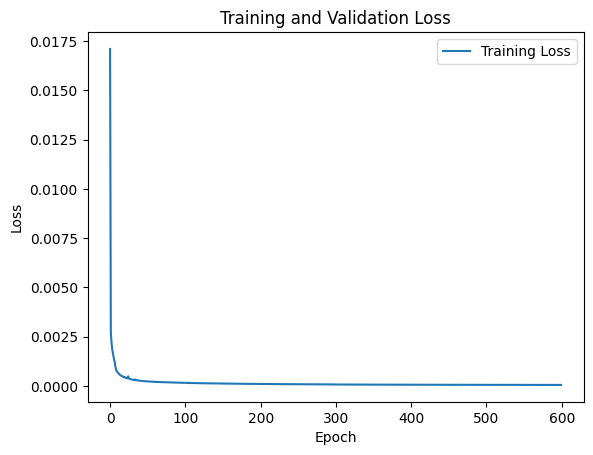

270/270 [==============================] - 0s 1ms/step
Processing slice: Start = 0, End = 0, Shape = (1, 25)
1/1 [==============================] - 0s 104ms/step
Reconstructed shape: (1, 25)
Processing slice: Start = 0, End = 1, Shape = (2, 25)
1/1 [==============================] - 0s 30ms/step
Reconstructed shape: (2, 25)
Processing slice: Start = 0, End = 2, Shape = (3, 25)
1/1 [==============================] - 0s 39ms/step
Reconstructed shape: (3, 25)
Processing slice: Start = 0, End = 3, Shape = (4, 25)
1/1 [==============================] - 0s 36ms/step
Reconstructed shape: (4, 25)
Processing slice: Start = 0, End = 4, Shape = (5, 25)
1/1 [==============================] - 0s 30ms/step
Reconstructed shape: (5, 25)
Processing slice: Start = 0, End = 5, Shape = (6, 25)
1/1 [==============================] - 0s 35ms/step
Reconstructed shape: (6, 25)
Processing slice: Start = 0, End = 6, Shape = (7, 25)
1/1 [==============================] - 0s 331ms/step
Reconstructed shape: (7, 25

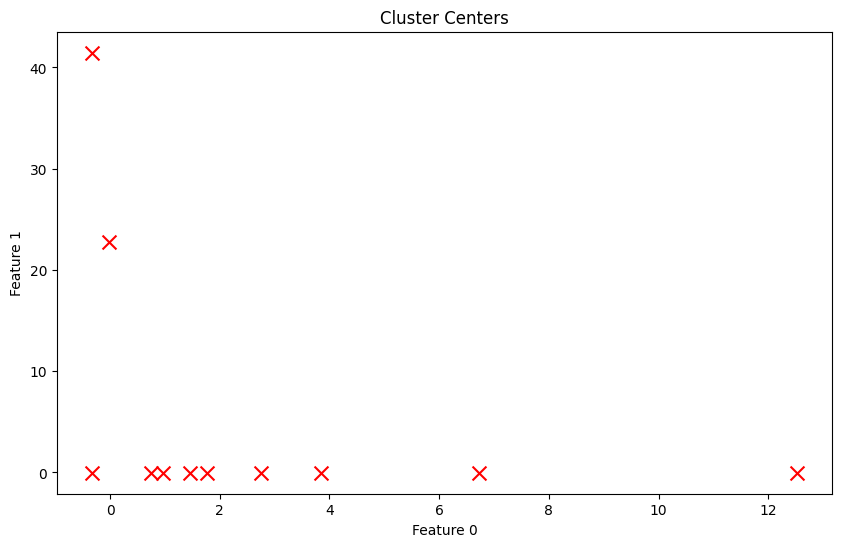

Shape of training data: (8405, 200, 8)
Shape of test data: (8269, 200, 8)
Epoch 1/30
263/263 [==============================] - 619s 2s/step - loss: 0.2055 - lr: 0.0010
Epoch 2/30
263/263 [==============================] - 634s 2s/step - loss: 0.1821 - lr: 0.0010
Epoch 3/30
263/263 [==============================] - 754s 3s/step - loss: 0.1786 - lr: 0.0010
Epoch 4/30
263/263 [==============================] - 790s 3s/step - loss: 0.1775 - lr: 0.0010
Epoch 5/30
263/263 [==============================] - 875s 3s/step - loss: 0.1755 - lr: 0.0010
Epoch 6/30
263/263 [==============================] - 1086s 4s/step - loss: 0.1743 - lr: 0.0010
Epoch 7/30
263/263 [==============================] - 652s 2s/step - loss: 0.1727 - lr: 0.0010
Epoch 8/30
263/263 [==============================] - 598s 2s/step - loss: 0.1709 - lr: 0.0010
Epoch 9/30
263/263 [==============================] - 553s 2s/step - loss: 0.1689 - lr: 0.0010
Epoch 10/30
263/263 [==============================] - 529s 2s/step - 

In [15]:
parent_dir = os.path.dirname(os.getcwd())

labeled_anomalies_file = os.path.join(parent_dir, 'data','processed','labeled_anomalies.csv')
labeled_anomalies = pd.read_csv(labeled_anomalies_file)

channels = labeled_anomalies[labeled_anomalies['spacecraft'] == 'SMAP']
channels = channels['chan_id'].to_list()

print(channels)

final_predictions = labeled_anomalies.copy()
# Add a columns for f1 score, precision, recall, tp, tn, fp, fn to final predictions dataframe
final_predictions['f1'] = 0.0
final_predictions['precision'] = 0.0
final_predictions['recall'] = 0.0
final_predictions['tp'] = 0
final_predictions['tn'] = 0
final_predictions['fp'] = 0
final_predictions['fn'] = 0
final_predictions['predicted_anomaly_sequences'] = [[] for _ in range(len(final_predictions))]

activation_function = 'relu'

# train_channel = 'D-1.npy'
test_channel = 'D-4.npy'
stream = test_channel[:-4]

final_df = pd.DataFrame()    
# print(f'Currently working on {channel[:-4]} Channel')

# train_df = pd.DataFrame(np.load(os.path.join(parent_dir, 'data','raw','train',f'{train_channel}')))
test_df = pd.DataFrame(np.load(os.path.join(parent_dir, 'data','raw','test',f'{test_channel}')))
final_df['telemetry'] = test_df.iloc[:, 0]

# scaler = StandardScaler()
# train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
# test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

# new_train, new_test = feature_engineering(train_df,test_df)
# train_df = pd.concat([train_df, new_train], axis=1)
# test_df = pd.concat([test_df, new_test], axis=1)

test_latent_representation, train_latent_representation, autoencoder = train_autoencoder(train_df, test_df,activation_function)
test_latent_representation = pd.DataFrame(test_latent_representation)
train_latent_representation = pd.DataFrame(train_latent_representation)
test_latent_representation.to_csv('test_latent_representation.csv')
train_latent_representation.to_csv('train_latent_representation.csv')

# Perform Sliding Window Autoencoder to get reconstruction loss
final_df  = get_reconstruction_loss(autoencoder, test_df,final_df)

# Example usage
# eps_estimate = estimate_eps(train_latent_representation)
    
# Perform clustering
# final_df  = perform_dbscan(test_latent_representation, train_latent_representation, eps_estimate, train_latent_representation.shape[1]*2, final_df)
final_df = perform_kmeans_with_refinement(test_latent_representation, train_latent_representation, range(3,50), final_df)

# Get LSTM predictions
final_df  = lstm_model(train_latent_representation, test_latent_representation,final_df)
final_df  = distances_recon_concat_ground_truth(final_df, labeled_anomalies, stream)

# Save the final_df by channel name
final_df.to_csv(os.path.join(parent_dir, 'data','processed',activation_function,f'{stream}_{activation_function}_final_df.csv'), index=False)

print('---'*10)
print('Here are the final evaluation results')



In [16]:
def plot(final_df):
    # Plot the anomaly score
    scaler = MinMaxScaler()
    final_df[['kmeans_anomaly_score_SMA', 'recon_losses_SMA', 'lstm_error_SMA']] = scaler.fit_transform(final_df[['kmeans_anomaly_score_SMA', 'recon_losses_SMA', 'lstm_error_SMA']])

    x = final_df['kmeans_anomaly_score_SMA']
    y = final_df['recon_losses_SMA']
    z = final_df['lstm_error_SMA']
    color = final_df['actual_anomaly']  # Assuming this is categorical
    
    # Define your mapping
    legend_mapping = {0.0: 'Normal', 1.0: 'Anomaly'}
    
    # Create a 3D scatter plot with separate traces for each category in 'color'
    fig = go.Figure()
    for category in color.unique():
        fig.add_trace(go.Scatter3d(
            x=x[color == category],
            y=y[color == category],
            z=z[color == category],
            mode='markers',
            name=legend_mapping.get(category, str(category)),  # Use the mapping for the trace name
            marker=dict(
                size=6,
                color=category,
                colorscale='Viridis',
                opacity=0.8
            )
        ))

    # Set the title and labels
    fig.update_layout(scene=dict(
                        xaxis_title='Kmeans Anomaly Score',
                        yaxis_title='Recon Losses',
                        zaxis_title='LSTM Error'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10),
                    legend_title="Legend Title")
    fig.update_layout(showlegend=True)
    # Display the plot
    fig.show()

In [17]:
def apply_smooting(df):
    class_column = df['actual_anomaly']
    df = df.drop(columns=['actual_anomaly'])
    # Set the window size for the moving average
    window_size = 200  # You can change this value as per your requirement

    # Apply simple moving average and fill NaN values with the original values
    for column in df.columns:
        df[column + '_SMA'] = df[column].rolling(window=window_size).mean().fillna(df[column])

    return pd.concat([df, class_column], axis=1)


In [18]:
final_df = apply_smooting(final_df)
print(final_df.head())

   telemetry  recon_losses  kmeans_anomaly_score  lstm_error  telemetry_SMA  \
0       -1.0      0.000006              0.157593         0.0           -1.0   
1       -1.0      0.000006              0.157593         0.0           -1.0   
2       -1.0      0.000006              0.157593         0.0           -1.0   
3       -1.0      0.000006              0.157593         0.0           -1.0   
4       -1.0      0.000006              0.157593         0.0           -1.0   

   recon_losses_SMA  kmeans_anomaly_score_SMA  lstm_error_SMA  actual_anomaly  
0          0.000006                  0.157593             0.0             0.0  
1          0.000006                  0.157593             0.0             0.0  
2          0.000006                  0.157593             0.0             0.0  
3          0.000006                  0.157593             0.0             0.0  
4          0.000006                  0.157593             0.0             0.0  


In [19]:
plot(final_df)

<Axes: >

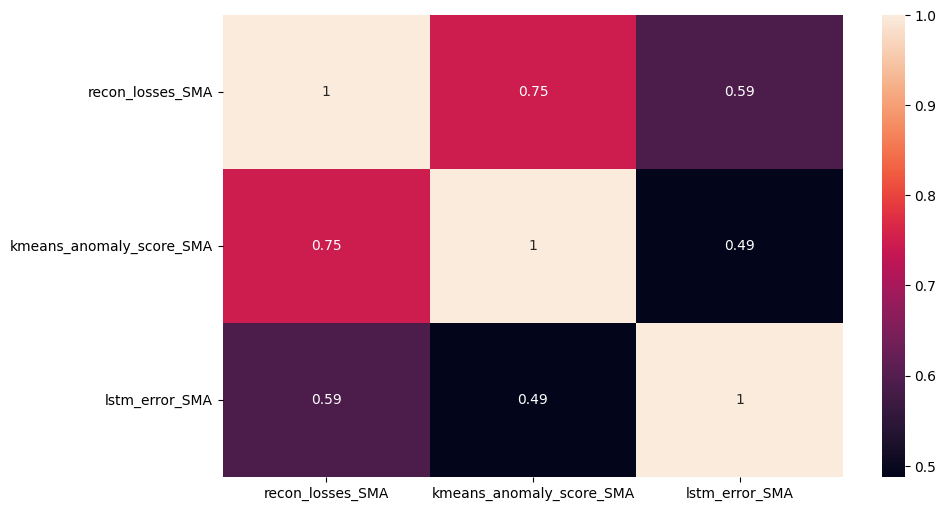

In [20]:
# Plot correlation matrix using 'recon_losses_SMA', 'kmeans_anomaly_score_SMA', 'lstm_error_SMA' of the final_df
import seaborn as sns
corr = final_df[['recon_losses_SMA', 'kmeans_anomaly_score_SMA', 'lstm_error_SMA']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True)

In [21]:
# Step 2: Combine 'kmeans_anomaly_score' and 'lstm_error' using a simple avera
test = (final_df['kmeans_anomaly_score_SMA'] + final_df['lstm_error_SMA'] + final_df['recon_losses_SMA']) / 3
print(test)

0       0.004912
1       0.004912
2       0.004912
3       0.004912
4       0.004912
          ...   
8468    0.685038
8469    0.702476
8470    0.719564
8471    0.727040
8472    0.727949
Length: 8473, dtype: float64


In [22]:
test = final_df[['kmeans_anomaly_score_SMA', 'lstm_error_SMA', 'recon_losses_SMA']]

In [23]:
# Define the percentile thresholds for considering an observation an anomaly
# Here, we'll use the top 5% as an example. Adjust as necessary.
high_percentile_threshold = 75

# Calculate the score values that correspond to these percentile thresholds for each column
percentile_values_high = test[['kmeans_anomaly_score_SMA', 'lstm_error_SMA', 'recon_losses_SMA']].quantile(high_percentile_threshold / 100.0)

print(percentile_values_high)


kmeans_anomaly_score_SMA    0.286301
lstm_error_SMA              0.081945
recon_losses_SMA            0.053473
Name: 0.75, dtype: float64


In [24]:
# Update 'predicted_labels' based on the percentile thresholds
# Initialize 'predicted_labels_percentile' to 0 (normal) as a default
# Ensure 'predicted_labels' is initialized in the 'test' dataframe before updating it in the loop
test['predicted_labels'] = 0  # This line ensures that 'predicted_labels' is initialized

for column in ['kmeans_anomaly_score_SMA', 'lstm_error_SMA', 'recon_losses_SMA']:
    # Classify as anomalies if score is above the high percentile threshold
    test.loc[test[column] > percentile_values_high[column], 'predicted_labels'] = 1

# Display the first few rows of the updated dataframe to verify the new classification
test.head(), percentile_values_high

C:\Users\AXW0J9E\AppData\Local\Temp\ipykernel_31700\1750803168.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(   kmeans_anomaly_score_SMA  lstm_error_SMA  recon_losses_SMA  \
 0                  0.014713             0.0          0.000024   
 1                  0.014713             0.0          0.000024   
 2                  0.014713             0.0          0.000024   
 3                  0.014713             0.0          0.000024   
 4                  0.014713             0.0          0.000024   
 
    predicted_labels  
 0                 0  
 1                 0  
 2                 0  
 3                 0  
 4                 0  ,
 kmeans_anomaly_score_SMA    0.286301
 lstm_error_SMA              0.081945
 recon_losses_SMA            0.053473
 Name: 0.75, dtype: float64)

In [25]:
# Initialize variables to store the aggregated results
aggregated_results = {
    'true_positives': 0,
    'false_positives': 0,
    'true_negatives': 0,
    'false_negatives': 0,
    'f1_score': 0,
    'precision': 0,
    'recall': 0,
}


In [26]:
# Calculate confusion matrix and extract TP, FP, TN, FN
tn, fp, fn, tp = confusion_matrix(final_df['actual_anomaly'], test['predicted_labels'].astype(int)).ravel()

# Aggregate the results
aggregated_results['true_positives'] += tp
aggregated_results['false_positives'] += fp
aggregated_results['true_negatives'] += tn
aggregated_results['false_negatives'] += fn
# Calculate precision, recall, and F1 score
aggregated_results['precision'] = aggregated_results['true_positives'] / (aggregated_results['true_positives'] + aggregated_results['false_positives'])
aggregated_results['recall'] = aggregated_results['true_positives'] / (aggregated_results['true_positives'] + aggregated_results['false_negatives'])
aggregated_results['f1_score'] = 2 * (aggregated_results['precision'] * aggregated_results['recall']) / (aggregated_results['precision'] + aggregated_results['recall'])

print(aggregated_results)

{'true_positives': 2431, 'false_positives': 1221, 'true_negatives': 4004, 'false_negatives': 817, 'f1_score': 0.7046376811594203, 'precision': 0.6656626506024096, 'recall': 0.7484605911330049}


In [27]:
def EDA_transformation(df):
    # Step 1: Logarithmic transformation of 'recon_losses'
    df['transformed_recon_losses'] = np.log(df['recon_losses_SMA'] + 1e-9)
    
    # Step 2: Combine 'kmeans_anomaly_score' and 'lstm_error' using a simple average
    df['combined_kmeans_and_lstm'] = (df['kmeans_anomaly_score_SMA'] + df['lstm_error_SMA']) / 2

    # Step 3: concatenate 'actual_anomaly' from df
    df['actual_anomaly'] = df['actual_anomaly']

    # Display the first few rows of the transformed and combined columns for verification
    scaler = MinMaxScaler()
    df['transformed_recon_losses'] = scaler.fit_transform(df[['transformed_recon_losses']])
    df['combined_kmeans_and_lstm'] = scaler.fit_transform(df[['combined_kmeans_and_lstm']])

    # Separate the data into normal and anomaly
    df_normal = df[df['actual_anomaly'] == 0]
    df_anomaly = df[df['actual_anomaly'] == 1]

    # Make plot with 'transformed_recon_losses' on x axis and 'combined_kmeans_and_lstm' on y axis
    # Add separate traces for normal and anomaly data
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_normal['transformed_recon_losses'], y=df_normal['combined_kmeans_and_lstm'], mode='markers', name='Normal'))
    fig.add_trace(go.Scatter(x=df_anomaly['transformed_recon_losses'], y=df_anomaly['combined_kmeans_and_lstm'], mode='markers', name='Anomaly'))
    fig.update_layout(title='Transformed Recon Losses vs Combined Kmeans and LSTM', xaxis_title='Log transformation Reconstruction Anomaly Score', yaxis_title='Combined K-means and LSTM Anomaly Score')
    fig.show()
    return df


In [28]:
df = final_df.copy()
df = EDA_transformation(df)
df.tail()

,telemetry,recon_losses,kmeans_anomaly_score,lstm_error,telemetry_SMA,recon_losses_SMA,kmeans_anomaly_score_SMA,lstm_error_SMA,actual_anomaly,transformed_recon_losses,combined_kmeans_and_lstm
8468,1.0,0.141821,1.160965,109.433228,0.941978,0.997086,0.446361,0.611668,1.0,0.999859,0.701151
8469,1.0,0.142269,1.160965,108.564072,0.942551,0.997810,0.446997,0.662620,1.0,0.999894,0.735820
8470,1.0,0.142108,0.846531,107.558975,0.943124,0.998524,0.447068,0.713100,1.0,0.999929,0.769792
8471,1.0,0.142974,11.569984,5.083139,0.943697,0.999267,0.466392,0.715460,1.0,0.999965,0.784364
8472,1.0,0.142814,0.846531,4.154447,0.944270,1.000000,0.466463,0.717383,1.0,1.000000,0.785705


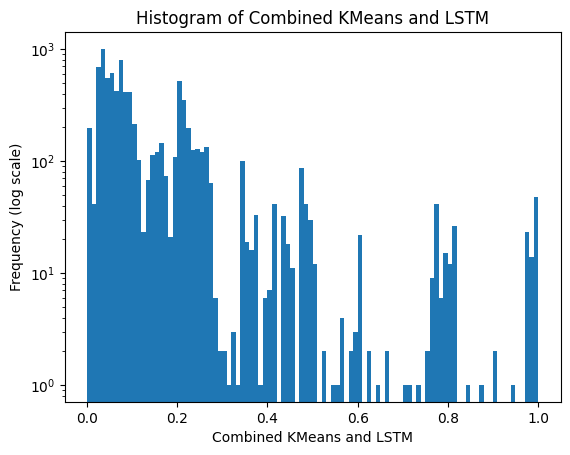

In [29]:
import matplotlib.pyplot as plt

# Let's examine the 'combined_kmeans_and_lstm' distribution and determine potential thresholds.
plt.hist(df['combined_kmeans_and_lstm'], bins=100, log=True)
plt.title('Histogram of Combined KMeans and LSTM')
plt.xlabel('Combined KMeans and LSTM')
plt.ylabel('Frequency (log scale)')
plt.show()

# Calculate thresholds at various percentiles
threshold = df['combined_kmeans_and_lstm'].quantile(0.642)

# Create a new column 'predicted_labels' where the value is 1 if 'combined_kmeans_and_lstm' is greater than the threshold, and 0 otherwise
df['predicted_labels'] = (df['combined_kmeans_and_lstm'] > threshold).astype(int)


In [30]:
# Calculate confusion matrix and extract TP, FP, TN, FN
tn, fp, fn, tp = confusion_matrix(df['actual_anomaly'], df['predicted_labels'].astype(int)).ravel()

# Aggregate the results
aggregated_results['true_positives'] += tp
aggregated_results['false_positives'] += fp
aggregated_results['true_negatives'] += tn
aggregated_results['false_negatives'] += fn
# Calculate precision, recall, and F1 score
aggregated_results['precision'] = aggregated_results['true_positives'] / (aggregated_results['true_positives'] + aggregated_results['false_positives'])
aggregated_results['recall'] = aggregated_results['true_positives'] / (aggregated_results['true_positives'] + aggregated_results['false_negatives'])
aggregated_results['f1_score'] = 2 * (aggregated_results['precision'] * aggregated_results['recall']) / (aggregated_results['precision'] + aggregated_results['recall'])

print(aggregated_results)

{'true_positives': 5440, 'false_positives': 1245, 'true_negatives': 9205, 'false_negatives': 1056, 'f1_score': 0.8254305439647978, 'precision': 0.8137621540762902, 'recall': 0.8374384236453202}


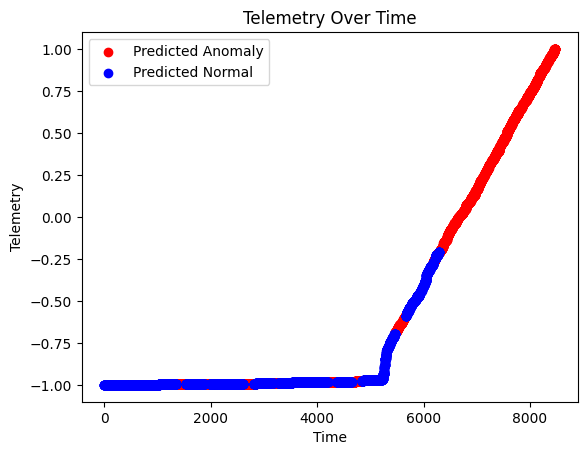

In [31]:
import matplotlib.pyplot as plt

# Create a boolean mask for the labels
mask = test['predicted_labels'] == 1

# Plot the points where the mask is True (i.e., the label is 1) as a scatter plot
plt.scatter(final_df[mask]['telemetry'].index, final_df[mask]['telemetry'], color='red', label='Predicted Anomaly')

# Plot the points where the mask is False (i.e., the label is 0) as a scatter plot
plt.scatter(final_df[~mask]['telemetry'].index, final_df[~mask]['telemetry'], color='blue', label='Predicted Normal')

plt.title('Telemetry Over Time')
plt.xlabel('Time')
plt.ylabel('Telemetry')
plt.legend()
plt.show()